# Neural Survival Clustering on SUPPORT Dataset

The SUPPORT dataset comes from the Vanderbilt University study
to estimate survival for seriously ill hospitalized adults.
(Refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
for the original datasource.)

In this notebook, we will apply Neural Survival Clustering on the SUPPORT data.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')

### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [2]:
import numpy as np

x = np.load('./ProcessedData/GeneCount_GroupNorm.npy',allow_pickle=True)
t = np.load('./ProcessedData/TTE_GroupNorm.npy',allow_pickle=True)
e = np.load('./ProcessedData/Event_GroupNorm.npy',allow_pickle=True)

In [3]:
print(x.shape)
print(t.shape)
print(e.shape)

(2942, 17526)
(2942,)
(2942,)


### Compute horizons at which we evaluate the performance of NSC

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of NSC to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [4]:
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.5]
times = np.quantile(t[e!=0], horizons).tolist()

In [5]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

At time 6.48
	 51.05 % observed risk 0
	 9.25 % observed risk 1


### Splitting the data into train, test and validation sets

We will train NSC on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_dev_ddh = minmax(t_dev)
t_val_ddh = minmax(t_val)
times_ddh = minmax(np.array(times))

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions, 
($K$), the latent representation, the learning rate for the Adam optimizer and the number of hidden layers and nodes.

In [7]:
from sklearn.model_selection import ParameterSampler

In [8]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'k': [2],
            'representation': [50, 100],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 30, random_state = 42)

### Model Training and Selection

In [9]:
from nsc import NeuralSurvivalCluster
import gc

ModuleNotFoundError: No module named 'sksurv'

In [10]:
gc.collect()
torch.cuda.empty_cache()

In [11]:
models = []
for param in params:
    model = NeuralSurvivalCluster(layers = param['layers'], act = param['act'], k = param['k'],
                                layers_surv = param['layers_surv'], representation = param['representation'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 10, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: 0.231: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


In [12]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Inference

Model prediction for the different patients and analysis of the results

In [13]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival= model.predict_survival(x_test, times_ddh.tolist())

### Evaluation

We evaluate the performance of NSC in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.

In [14]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [15]:
et_train = np.array([(e_train[i] == 1, t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i] == 1, t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
selection = (t_test < t_train.max()) | (e_test == 0)

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.5 quantile,
TD Concordance Index: 0.654191097535876
Brier Score: 0.11458337928232022
ROC AUC  0.6497538782163774 



## Cluster analysis

In this section, we display the learnt clusters and the impact of the different features on the membership to each cluster. This importance is obtained through permutation of the feature.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

In [18]:
clusters

array([[1.        , 1.        ],
       [0.99888382, 0.99872954],
       [0.99791155, 0.99772506],
       [0.99700146, 0.9968367 ],
       [0.99570297, 0.99562995],
       [0.99445573, 0.99452085],
       [0.99324363, 0.99347922],
       [0.99166734, 0.99216724],
       [0.99050828, 0.991228  ],
       [0.98823598, 0.98943781],
       [0.98786226, 0.98914904],
       [0.9874898 , 0.98886268],
       [0.98620236, 0.98788325],
       [0.98274401, 0.98532179],
       [0.97918926, 0.9827752 ],
       [0.97569875, 0.98034265],
       [0.97181493, 0.97770088],
       [0.96852902, 0.97551073],
       [0.96452775, 0.97289111],
       [0.96155718, 0.97097562],
       [0.95894037, 0.96930666],
       [0.95634463, 0.96766666],
       [0.95441106, 0.96645429],
       [0.95057646, 0.96407143],
       [0.94835883, 0.96270539],
       [0.94562913, 0.96103501],
       [0.94341391, 0.95968787],
       [0.94116649, 0.95832836],
       [0.93783735, 0.95632696],
       [0.93624363, 0.9553738 ],
       [0.

Text(0, 0.5, 'Survival Probability')

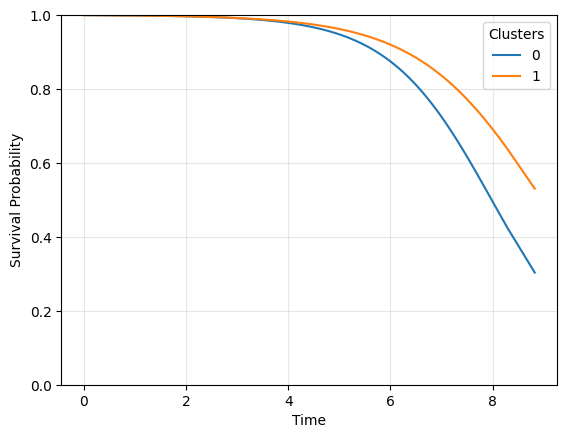

In [19]:
pd.DataFrame(clusters, index = times_cluster).plot()
plt.grid(alpha = 0.3)
plt.ylim(0, 1)
plt.legend(title = 'Clusters')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

In [20]:
times_cluster.shape

(100,)

In [21]:
#importance, confidence = model.feature_importance(x_train, t_train_ddh, e_train)

In [22]:
'''(pd.DataFrame({'Value': 100 * np.array(list(importance.values())), 'Conf': confidence.values()}, index = columns)).sort_values('Value').plot.bar(yerr = 'Conf')
plt.ylabel('% change in NLL')
plt.xlabel('Covariates')
plt.grid(alpha = 0.3)'''

"(pd.DataFrame({'Value': 100 * np.array(list(importance.values())), 'Conf': confidence.values()}, index = columns)).sort_values('Value').plot.bar(yerr = 'Conf')\nplt.ylabel('% change in NLL')\nplt.xlabel('Covariates')\nplt.grid(alpha = 0.3)"